# Exploring customer segmentation and customer lifetime value for sales forecasting

**Background**

A UK-based company that supplies unique all-occasion gifts, such as themed dishware and trendy household items, takes pride in offering an unparalleled selection of carefully curated products designed to enhance every special moment. With over 1 million transactions realized between 2009 and 2011, this company provides products for wholesalers, retail stores, or resellers. This means it sells to sales channel partners and stores that are looking for unique gift ideas and products for their customers. As a product supplier for wholesale stores, the company deals with cancellations and bulk orders. Due to the nature of the gift-giving product category, the volume of business is high during peak holiday seasons, which in the UK occur from October to December.


The challenge is to better understand the customer data available and historical sales, to identify an opportunity to build targeted segments to market and to forecast sales.


Another key factor to keep in mind is that the analysis also considers cancellations and returns, so the segmentation approach should identify customer groups who are qualified customers who generally don’t show indicators of returning or canceling their orders. A key goal in retail is to ensure profitable sales that minimize returns and cancellations, which impacts the profitability of the organization.

**Objectives**

- Understand the data of the challenge and its features.
- Perform an exploratory data analysis to identify patterns and insights that help solve the challenge.
- Prepare the data that will be necessary to solve the challenge.
- Establish a customer segmentation technique and describe the results.
- Define the strategy, implement the forecast model for each customer segment, and describe the results.
- Present the results and main insights found in the execution of the challenge.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")


In [3]:
dat = pd.read_excel('online_retail_II.xlsx')
dat.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# 1. The Raw Data

| Data Element | Type     | Description                                                                                                                                               |
|--------------|----------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| Invoice      | object   | Invoice number. A 6-digit integral number is uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. |
| StockCode    | object   | Product (item) code. A unique 5-digit integral number is assigned to each distinct product.                                                               |
| Description  | object   | Product (item) name. |
| Quantity     | int64    | The quantities of each product (item) per transaction. |
| InvoiceDate  | datetime | Invoice date and time. The day and time when a transaction was generated. |
| Price        | float64  | Unit price.  Product price per unit in pounds (£). |
| Customer ID  | int64    | Customer number.  A unique 5-digit integral number is assigned to each customer. |
| Country      | object   | Country name. The name of the country where a customer resides. |


# 2. Cleaning

In [4]:
# Cancellations/Returns
dat['Cancelled'] = False
dat.loc[dat.Invoice.astype(str).str.startswith('C'), 'Cancelled'] = True

# Nans
for col in dat.columns:
    print(f'there are {sum(dat[col].isna())} Nans in the {col} column')

# Start simple. just drop them    
df = dat.dropna() 
print(f' {dat.size - df.size} rows were dropped due to nans ({((dat.size - df.size)/ dat.size) * 100} %).') 

# Distribute the year, month, day, and time components into separate columns
df['Year'] = df.InvoiceDate.dt.year
df['Month'] = df.InvoiceDate.dt.month
df['Week'] = df.InvoiceDate.dt.isocalendar().week
df['Day'] = df.InvoiceDate.dt.day
df['Time'] = df.InvoiceDate.dt.time

df['Total'] = df.Quantity * df.Price
df = df[df.Cancelled == False].reset_index()
# Dropping test transactions
df = df[~df.StockCode.astype(str).str.contains('TEST')].reset_index(drop=True)

df.set_index('InvoiceDate', inplace=True)


there are 0 Nans in the Invoice column
there are 0 Nans in the StockCode column
there are 2928 Nans in the Description column
there are 0 Nans in the Quantity column
there are 0 Nans in the InvoiceDate column
there are 0 Nans in the Price column
there are 107927 Nans in the Customer ID column
there are 0 Nans in the Country column
there are 0 Nans in the Cancelled column
 971343 rows were dropped due to nans (20.53948818275762 %).


Computing Sales
We will compute sales over year/month/week/ and day 

In [11]:
#weekly_sales = df['Total']..sum().plot()
daily = df['Total'].resample('D').sum()
weekly_sales = df['Total'].resample('W').sum()


In [6]:
df.loc[(df.Year == 2010) & (df.Month == 1) & (df.Day == 3) ]

,index,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,Cancelled,Year,Month,Week,Day,Time,Total


In [5]:
# Select features for segmentation
# Here, we'll use 'Recency', 'Frequency', and 'Monetary' for an RFM-based segmentation
# You can define these metrics based on your specific business context
df.reset_index(inplace=True)
rfm_data = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (pd.Timestamp.now() - x.max()).days,  # Recency
    'Invoice': 'count',  # Frequency
    'Price': 'sum'  # Monetary
}).reset_index()
rfm_data.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']


In [6]:
rfm_data

,Customer ID,Recency,Frequency,Monetary
0,12346.0,4864,24,169.36
1,12347.0,4702,71,162.95
2,12348.0,4773,20,14.39
3,12349.0,4742,102,875.34
4,12351.0,4710,21,49.46
...,...,...,...,...
4307,18283.0,4717,230,498.82
4308,18284.0,4766,28,91.09
4309,18285.0,4995,12,100.20
4310,18286.0,4811,67,286.30


In [7]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])


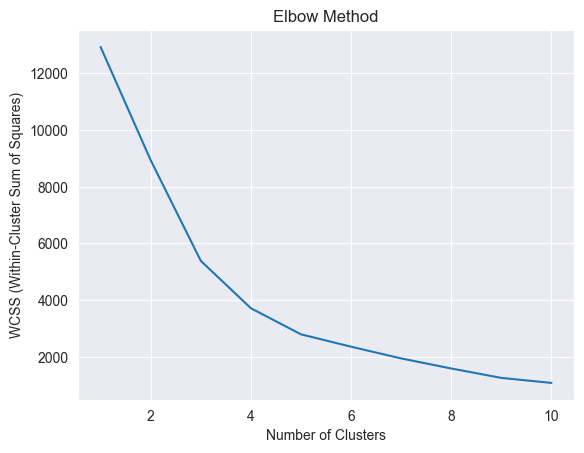

In [8]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method to identify the optimal number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()


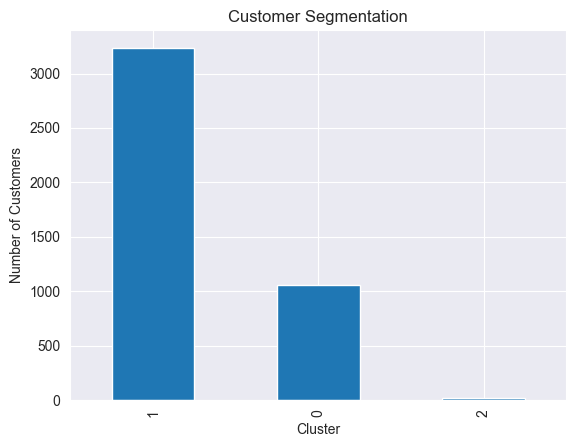

In [9]:
# Based on the Elbow Method plot, choose the optimal number of clusters
num_clusters = 3  # Adjust this based on your analysis

# Apply K-means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize the clusters
rfm_data['Cluster'].value_counts().plot(kind='bar')
plt.title('Customer Segmentation')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

# Now, rfm_data contains the customer segments (clusters)


Here we compute revenue per transaction (price x quantity) and identify transactions that were returned or cancelled. 

In [10]:
rfm_data

,Customer ID,Recency,Frequency,Monetary,Cluster
0,12346.0,4864,24,169.36,0
1,12347.0,4702,71,162.95,1
2,12348.0,4773,20,14.39,1
3,12349.0,4742,102,875.34,1
4,12351.0,4710,21,49.46,1
...,...,...,...,...,...
4307,18283.0,4717,230,498.82,1
4308,18284.0,4766,28,91.09,1
4309,18285.0,4995,12,100.20,0
4310,18286.0,4811,67,286.30,1


In [11]:
df['Cluster'] = None

In [12]:

for customer in tqdm(df['Customer ID'].unique()):
    c = rfm_data.loc[rfm_data['Customer ID'] == customer].Cluster.values[0]
    df.loc[df['Customer ID'] == customer, 'Cluster'] = c    

100%|██████████| 4312/4312 [00:06<00:00, 619.33it/s]


In [13]:
#aggregate data for forecast
df['Total'] = df.Price * df.Quantity
xx = df.Country.astype(str).str.get_dummies()
df = pd.concat([df, xx], axis=1)
df.groupby(['Country','Cluster','Customer ID', 'Invoice', 'InvoiceDate']).Total.sum()

Country      Cluster  Customer ID  Invoice  InvoiceDate        
Australia    0        12392.0      506115   2010-04-27 14:04:00     234.75
                      12416.0      498550   2010-02-21 10:19:00     202.56
                      16321.0      489450   2009-12-01 10:36:00     196.10
                                   502275   2010-03-23 16:01:00      34.80
             1        12386.0      537676   2010-12-08 09:53:00     258.90
                                                                    ...   
Unspecified  1        16320.0      495919   2010-01-27 13:29:00     823.15
                                   515475   2010-07-13 09:35:00    1189.94
                                   515624   2010-07-14 10:08:00    1189.94
                                   522098   2010-09-12 13:51:00    1387.50
West Indies  1        18140.0      520018   2010-08-23 11:58:00     536.41
Name: Total, Length: 19238, dtype: float64

# Forcast

In [16]:
rfm_data

,Customer ID,Recency,Frequency,Monetary,Cluster
0,12346.0,4864,24,169.36,0
1,12347.0,4702,71,162.95,1
2,12348.0,4773,20,14.39,1
3,12349.0,4742,102,875.34,1
4,12351.0,4710,21,49.46,1
...,...,...,...,...,...
4307,18283.0,4717,230,498.82,1
4308,18284.0,4766,28,91.09,1
4309,18285.0,4995,12,100.20,0
4310,18286.0,4811,67,286.30,1


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split

for seg in range(3):    
    # Select a customer segment (e.g., segment 0)
    segment_data = df[df['Cluster'] == seg]
    
    # Train a Random Forest Regressor for the selected segment
    X_segment = segment_data[['InvoiceDate', 'Price']+ [col for col in xx.columns]]
    y_segment = segment_data['Total']
    
    # Feature engineering (convert InvoiceDate to numeric features)
    X_segment['Year'] = X_segment['InvoiceDate'].dt.year
    X_segment['Month'] = X_segment['InvoiceDate'].dt.month
    X_segment['Day'] = X_segment['InvoiceDate'].dt.day
    X_segment['Hour'] = X_segment['InvoiceDate'].dt.hour
    
    X_segment = X_segment.drop(columns=['InvoiceDate'])
    
    # Split the segment data into training and testing sets
    X_train_segment, X_test_segment, y_train_segment, y_test_segment = train_test_split(X_segment, y_segment, test_size=0.2, random_state=42)
    
    # Train the model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train_segment, y_train_segment)
    
    # Make predictions
    y_pred_segment = model.predict(X_test_segment)
    
    # Evaluate the model
    rmse_segment = np.sqrt(mean_squared_error(y_test_segment, y_pred_segment))
    print(f'Root Mean Squared Error for Segment {seg}: {rmse_segment}')



Root Mean Squared Error for Segment 0: 39.139797984555074
Root Mean Squared Error for Segment 1: 61.10862627587965
Root Mean Squared Error for Segment 2: 57.08403798388702


<Axes: xlabel='InvoiceDate'>

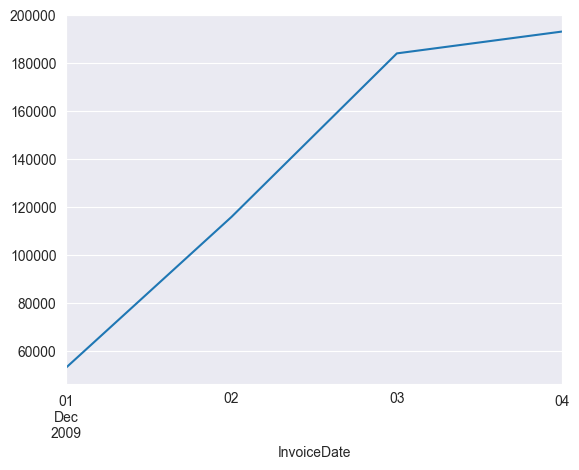

In [49]:
df = dat.iloc[:10000]
df.Total.resample('D').sum().cumsum().plot()
#df

# ARIMA

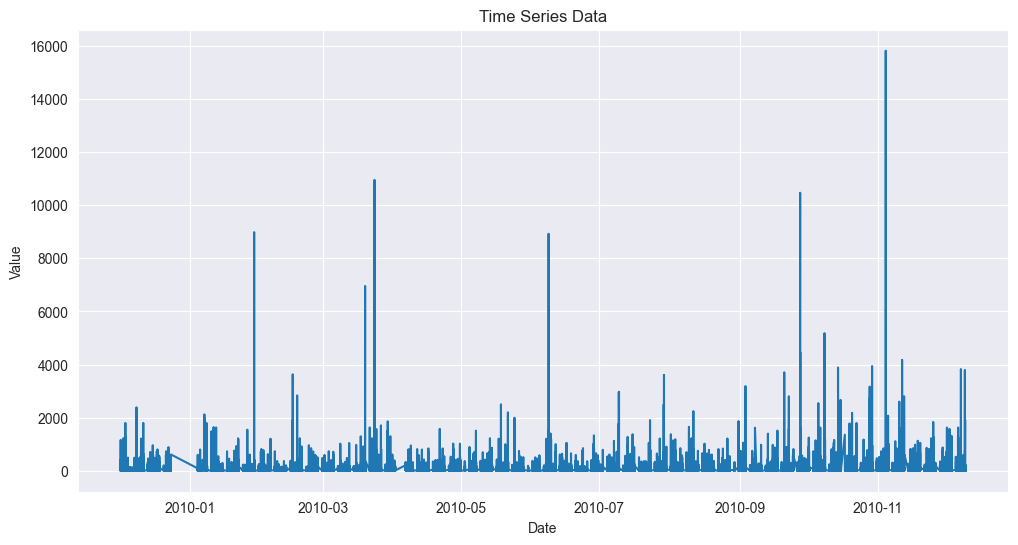

ADF Statistic: -57.63273848367417
p-value: 0.0


TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [18]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load your time series data
# data = pd.read_csv('time_series_data.csv')

# Assuming your dataset has a 'Date' column and a 'Value' column

df.set_index('InvoiceDate', inplace=True)

# Visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(df['Total'])
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Check for stationarity using the Dickey-Fuller test
result = adfuller(df['Total'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If the time series is not stationary, you can take the first difference
data_diff = df.diff().dropna()

# Visualize the differenced time series
plt.figure(figsize=(12, 6))
plt.plot(data_diff)
plt.title('Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.show()

# Plot ACF and PACF to determine ARIMA parameters
plot_acf(data_diff, lags=20)
plot_pacf(data_diff, lags=20)
plt.show()

# Fit an ARIMA model
p = 1  # Order of AR
d = 1  # Order of differencing
q = 1  # Order of MA

model = ARIMA(df, order=(p, d, q))
results = model.fit()

# Forecast future data points
forecast_steps = 10  # Adjust the number of steps to forecast
forecast, stderr, conf_int = results.forecast(steps=forecast_steps)

# Visualize the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df, label='Original Data')
plt.plot(pd.date_range(start=df.index[-1], periods=forecast_steps+1, closed='right'), [df.iloc[-1]] + list(forecast), label='Forecast', linestyle='--')
plt.title('Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()